In [1]:
import filepath

In [2]:
import torch
import numpy as np
import sympy as sp
from abc import ABC
from typing import List, Dict, Tuple
from panda3d.core import VBase3
from panda3d.core import Vec3
from panda3d.core import Quat
from panda3d.core import invert

from panda3d_game.game_object import GameObject, PhysicsGameObject
from panda3d.core import TransformState
# 
from util.geometry import batch_transform, createPosIndicatorNPth
from art.basic import geom_frm_faces, create_cylinder_node, create_cylinder
from panda3d.core import GeomPrimitive
from panda3d.core import (
    Geom,
    GeomNode,
    GeomTriangles,
    GeomVertexData,
    GeomVertexFormat,
    GeomVertexWriter,
    GeomEnums, Vec3, LPoint3f
)    
from panda3d.core import GeomNode, NodePath, GeomVertexReader, BitMask32
from art.basic import uv_curve_surface, uv_curve_surface_lambda
from panda3d.bullet import (
    BulletWorld, BulletRigidBodyNode, BulletTriangleMesh, 
    BulletTriangleMeshShape, BulletDebugNode,
      BulletHingeConstraint, BulletGenericConstraint,
    BulletShape, BulletMinkowskiSumShape,BulletCylinderShape,
BulletConvexHullShape
)
from panda3d_game.constraints import FixedConstraint
# class RigidNodePath(NodePath):
#     def setPos(*args,**kwargs):
#         super().setPos(*args,**kwargs)
#         self.node().setTransform(self.getTransform())

In [3]:
from util.bullet_geometry import *
from util.geometry import *
from game.space.machinen.fly_wheel.cube_fly_wheel.fly_wheel import FlyWheel

In [4]:

class MagicThruster(Thruster):
    def __init__(
        self, name, radius, length, rigid_length, direction=None,
        mount_shift=2,
        mass = 1
    ):
        # thrust is magically produced 
        # does not has limit 
        # does not rely on any machanism
        # does not consume fuels
        # used for testing
        super().__init__()
        self._thrust = 0
        self.name = f"Thr.{name}"
        self.radius = float(radius)
        self.length = float(length)
        self.rigid_length = float(rigid_length)
        self.mount_shift = float(mount_shift)
        self.mass = float(mass)
        if direction is None:
            self.direction_init = (1,0,0)
        else:
            direction_sum = abs(sum(direction))
            self.direction_init = (
                direction[0]/direction_sum, 
                direction[1]/direction_sum,
                direction[2]/direction_sum
            )  # todo: setter
        
        self.geom = create_cylinder_node(
            radius=self.radius, height=self.length, 
            name=self.name, lon_res=8
        )
        self.geom_np = NodePath(self.geom)
        self.geom_np.lookAt(Vec3(self.direction_init))
        self.rigid_node = BulletRigidBodyNode(self.name)
        self.rigid_node.setMass(self.mass)
        # TODO: create cylinder shape
        # TODO: add cylinder shape with transformed 
        cylindershape = BulletCylinderShape(
            radius=self.radius, height=self.rigid_length, 
            up=1
        )
        shape_transform_lookAt = makeLookAt(Vec3(self.direction_init))
        rigid_shift = self.length - self.rigid_length/2
        shape_transform_pos = TransformState.makePos((
            self.direction_init[0] * rigid_shift,
            self.direction_init[1] * rigid_shift,
            self.direction_init[2] * rigid_shift
        ))
        # shape_transform = shape_transform_lookAt.compose(shape_transform_pos)                                     
        shape_transform = shape_transform_pos.compose(shape_transform_lookAt)
        self.rigid_node.addShape(cylindershape, shape_transform)
        self.rigid_np = NodePath(self.rigid_node)
        self.geom_np.reparentTo(self.rigid_np)
        self.attachPoint = TransformState.makePos((
            self.direction_init[0] * -self.mount_shift,
            self.direction_init[1] * -self.mount_shift,
            self.direction_init[2] * -self.mount_shift,
        ))
        # self.attachPoint = self.geom_np.getTransform()
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)

    @property
    def thrust_val(self) -> sp.Expr:
        return self._thrust_val

    @property
    def thrust(self) -> torch.Tensor:  # in game scale, without unit 
        return self.thrust_val * self.thrust_dire

    @property
    def thrust_dire(self) -> torch.Tensor:
        # thrust direction
        # fixed for non vector thrust
        return torch.Tensor(self.direction_init)
        
class HallEffectThruster(Thruster, ElectricityAppliance):
    def get_current(self):
        pass
    pass
    
class ThrusterSet(PhysicsGameObject):

    @property
    def thrusters(self) -> List[Thruster]:
        pass
    pass



class Obj000_ThrusterSet(PhysicsGameObject):
    #TODO: enum gears
    def reparentTo(self, other):
        # if other is game object: TODO
        self.mainPath.reparentTo(other)
        for c in self.children:
            c.reparentTo(other)

    def __init__(self, name, unit, is_up=False):
        PhysicsGameObject.__init__(self)
        # scale_factor = float(scale_factor)
        self.name = f"ThruS.{name}"
        self.unit = unit
        self.ridge_mass = 10 * tonne
        self.thruster_length = 50 * meter
        self.thruster_radius = 20 * meter
        self.thruster_rigid_length = 10 * meter
        scale_factor = float(1*meter / unit["length"])
        
        # self.tasks = []
        
        ridge_y = torch.arange(0,40+5,step=5).float()
        ridge_z = 0.03 * (ridge_y ** 2) - 20 
        ridge_y = ridge_y + 20
        ridge_y = torch.hstack([-ridge_y.flip(dims=[0]), ridge_y]) # mirror effect
        ridge_z = torch.hstack([ridge_z.flip(dims=[0]), ridge_z])
        ridge_x_front = torch.ones_like(ridge_y) * 20
        ridge_x_back  = torch.ones_like(ridge_y) * -20
        # FIXME: rename
        if is_up:
            ridge_z = - ridge_z # FIXME: flip
        _1 = torch.concat([ridge_x_front.unsqueeze(-1),ridge_y.unsqueeze(-1),ridge_z.unsqueeze(-1)],dim=-1)
        _2 = torch.concat([ridge_x_back.unsqueeze(-1),ridge_y.unsqueeze(-1),ridge_z.unsqueeze(-1)],dim=-1)
        y_mean = torch.mean(ridge_y).item()
        z_mean = torch.mean(ridge_z).item()
        frontend = torch.ones_like(_1) * torch.Tensor([20, y_mean,z_mean])
        backend  = torch.ones_like(_2) * torch.Tensor([-20, y_mean, z_mean])
        # [4,18,3 ]
        ridge_xyz = torch.concat([frontend.unsqueeze(0), _1.unsqueeze(0), _2.unsqueeze(0), backend.unsqueeze(0)],dim=0)
        ridge_xyz = ridge_xyz * scale_factor
        self.geom_node = GeomNode(self.name)
        self.ridge_geom = uv_curve_surface(
            name = f"rg.{self.name}",
            coord_mat=ridge_xyz,
            is_u_loop=False,
            is_v_loop=True,
        )
        self.geom_node.addGeom(self.ridge_geom)
        self.ridge_np = NodePath(self.geom_node)
        # FIXME: use vertex instead of geom 
        convec_hull_shape = create_convex_hull_shape(
            geoms=[self.ridge_geom]
        )
        self.rigid_node = BulletRigidBodyNode(f"{self.name}.rigid")
        self.rigid_node.setMass(float(self.ridge_mass / unit["mass"]))
        self.rigid_node.addShape(convec_hull_shape)
        self.rigid_np = NodePath(self.rigid_node)
        self.ridge_np.reparentTo(self.rigid_np)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)

        if is_up:
            self.thruster_loc = {
                "up":(0,0,20),
                "forward":(20,0,0),
                "backward":(-20,0,0)
            }
        else:
            self.thruster_loc = {
                "down":(0,0,-20),
                "forward":(20,0,0),
                "backward":(-20,0,0)
            }
        self.thrusters_d = {}
        for loc_key, loc in self.thruster_loc.items():
            loc_scaled = (
                loc[0]*scale_factor,
                loc[1]*scale_factor,
                loc[2]*scale_factor
            )
            t = MagicThruster(
                name=f"{self.name}.{loc_key}",
                radius=self.thruster_radius / self.unit["length"],
                length=self.thruster_length / self.unit["length"],
                rigid_length=self.thruster_rigid_length / self.unit["length"],
                mount_shift=20 * meter/self.unit["length"],
                direction=loc_scaled
            )
            self.thrusters_d[loc_key] = t
            t.setPos(loc_scaled)
            
        self.children = list(self.thrusters_d.values())
        self.shellAttachPoint = TransformState.makePos((0,0,0))
        # for loc_key, loc in self.thruster_loc.items():
        #     print(loc, type(loc))
        #     t = TransformState.makePos(loc)
        self.thrusterAttachPoints = {
            loc_key: TransformState.makePos((0,0,0))
            for loc_key, loc in self.thruster_loc.items()
        }
        self.thrusterConstraints = {
            loc_key : FixedConstraint(
                self.thrusters_d[loc_key].rigid_node, self.rigid_node, 
                self.thrusters_d[loc_key].attachPoint, self.thrusterAttachPoints[loc_key], True
            # LPoint3f(0,0,0), # LPoint3f(0,0,0)
            )
            for loc_key in self.thruster_loc.keys()
        }
        self.constraints = self.thrusterConstraints.values()

        # attach points: two attach points FIXME
            
    @property
    def thrusters(self) -> List[Thruster]:
        return self.children
    pass



        
class Shuttle(GameObject):
    pass

class Obj000(Shuttle, PhysicsGameObject):

    def reparentTo(self, other):
        for child in self.children:
            child.reparentTo(other)

    @property
    def mainPath(self):
        # return self.node_path
        return self.shell.mainPath

    def toBulletWorld(self, bulletWorld):
        # self.shell.toBulletWorld(bulletWorld)
        for c in self.children:
            c.toBulletWorld(bulletWorld)
        for c in self.constraints:
            bulletWorld.attachConstraint(c)
        # self.flywheel.toBulletWorld(bulletWorld) FIXME
        # bulletWorld.attachConstraint(self.fixed_constraint)
    
    def __init__(self, unit, name):
        PhysicsGameObject.__init__(self)
        self.unit = unit
        self.name = name
        # self.node_path = NodePath()
        self.shell_radius_minor = 1 * meter
        self.shell_radius_major = 100 * meter
        self.frame_thickness = 0.1 * meter
        self.keel_thickness = 1 * meter
        self.shell_mass = 1000 * tonne
        self.shell = Obj000_shell(
            r1=self.shell_radius_minor / self.unit["length"],
            r2=self.shell_radius_major / self.unit["length"],
            a=0.02*(self.unit["length"]/meter),
            frame_thickness=self.frame_thickness / self.unit["length"],
            keel_thickness=self.keel_thickness / self.unit["length"],
            mass=self.shell_mass / self.unit["mass"],
            name=self.name
        )
        # self.shell.reparentTo(self.node_path)
        self.fly_wheel_length = 30 * meter 
        self.fly_wheel_width = 3 * meter
        self.thrusterset_shift = 100 * meter
        
        self.flywheel = FlyWheel(
            name=self.name,
            length=self.fly_wheel_length / self.unit["length"],
            frame_width=self.fly_wheel_width / self.unit["length"],
            frame_mass=1,single_wheel_mass=1,
        )
        self.flywheel_constraint = FixedConstraint(
            self.flywheel.rigid_node, self.shell.rigid_node, 
            # Vec3(0, 0, 0)
            self.flywheel.attachPoint, self.shell.flywheelAttachPoint,True
            # LPoint3f(0,0,0), # LPoint3f(0,0,0)
        )
        
        self.thrusterSetTop = Obj000_ThrusterSet(
            name=f"{self.name}.top",
            unit=self.unit,
            is_up=True
        )
        self.thrusterSetTop.setPos(0,0,float(self.thrusterset_shift/self.unit["length"]))
        self.thrAttachPointTop = TransformState.makePos((0,0,float(self.thrusterset_shift/self.unit["length"])))
        # self.thrusters_up.ridge_np.reparentTo(self.mainPath)
        self.thrusterSetBot = Obj000_ThrusterSet(
            name=f"{self.name}.bot",
            unit=self.unit,
            is_up=False
        )
        self.thrusterSetBot.setPos(0,0,-float(self.thrusterset_shift/self.unit["length"]))
        self.thrAttachPointBot = TransformState.makePos((0,0,-float(self.thrusterset_shift/self.unit["length"])))
        self.thr_constraint_top = FixedConstraint(
            self.thrusterSetTop.rigid_node, self.shell.rigid_node,
            self.thrusterSetTop.shellAttachPoint, self.thrAttachPointTop,
            True
        )
        self.thr_constraint_bot = FixedConstraint(
            self.thrusterSetBot.rigid_node, self.shell.rigid_node,
            self.thrusterSetBot.shellAttachPoint, self.thrAttachPointBot,
            True
        )
        self.constraints = [
            self.flywheel_constraint, 
            self.thr_constraint_top,
            self.thr_constraint_bot
        ]
        self.children = [self.shell, self.flywheel, self.thrusterSetTop, self.thrusterSetBot]

    def setFlyWheelTorque(self):
        pass

    def getVelocity(self):
        pass

    def getAngularVelocity(self):
        pass

    def getPos(self):
        pass
        

# class FixedConstraint(BulletGenericConstraint):
#     def __init__(self,

In [5]:

from panda3d.bullet import BulletWorld, BulletRigidBodyNode,  BulletDebugNode

class Obj000_shell(PhysicsGameObject):
    def setScale(self, scale):
        # FIXME
        # self.geom_np.setScale(scale)
        self.rigid_np.setScale(scale)

    def setColor(self, r,g,b,a):
        self.geom_np.setColor(r,g,b,a)

    def setTexture(self,t):
        self.geom_np.set_texture(t)
        
    def __init__(self, r1, r2, a, frame_thickness, keel_thickness, name, mass=1):
        # print(r1, type(r1),float(r1))
        # FIXME: use sympy
        r1 = float(r1)
        r2 = float(r2)
        a = float(a)
        mass = float(mass)
        frame_thickness = float(frame_thickness)
        keel_thickness = float(keel_thickness)
        super().__init__()
        assert r2 >= r1
        self.r1 = r1
        self.r2 = r2
        self.a = a
        self.mass = mass
        self.frame_thickness = frame_thickness
        self.keel_thickness = keel_thickness
        self.name = "Shell.{}".format(name)
        self.geom_node = GeomNode(self.name)
        self.rigid_node = BulletRigidBodyNode(f"{self.name}.rigid")
        # 2 paraboloids in column coord
        self.n_step_shell = 6
        theta = torch.arange(start=0, end=2 * np.pi, step=np.pi/self.n_step_shell)
        step = (r2 - r1) / 6
        rho = torch.arange(start=r1, end=r2 + step, step=step)
        z_2_shift = self.a * self.r2 ** 2
        self.geom_c1 = uv_curve_surface_lambda(
            f"{self.name}.1",
            u=theta,v=rho,
            is_u_loop=True, is_v_loop=False,
            x_uv=lambda _theta, _rho: a * _rho ** 2 - z_2_shift,
            y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
            z_uv=lambda _theta, _rho: _rho * np.sin(-_theta),
            # FIXME geom node
        )
        self.geom_c2 = uv_curve_surface_lambda(
            f"{self.name}.2",
            u=theta,v=rho,
            is_u_loop=True, is_v_loop=False,
            x_uv=lambda _theta, _rho: -  a * _rho ** 2 + z_2_shift,
            y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
            z_uv=lambda _theta, _rho: _rho * np.sin(_theta),
            # FIXME geom node
        )
        self.geom_node.addGeom(self.geom_c1)
        self.geom_node.addGeom(self.geom_c2)
        self.geom_np = NodePath(self.geom_node)
        # convec_hull_shape = create_convex_hull_shape(
        #     geoms=[self.geom_c1,self.geom_c2]
        # )
        self.n_step_frame = 8
        step = (r2 - r1) / self.n_step_frame
        rho = torch.arange(start=r1, end=r2+step, step=step)[1:-1]
        z_2_shift = a * r2 ** 2
        pos_x = a * rho ** 2 - z_2_shift
        self.rigid_node.setMass(self.mass)
        for i in range(len(rho)):
            pos_xi = pos_x[i]
            ri = rho[i]
            shape = BulletCylinderShape(radius=ri, height=self.frame_thickness, up=0)
            self.rigid_node.addShape(shape, TransformState.makePos((pos_xi,0,0)))
            self.rigid_node.addShape(shape, TransformState.makePos((-pos_xi,0,0)))
       
        self.rigid_node.setRestitution(0)
        self.rigid_node.setFriction(0)
        
        self.rigid_np = NodePath(self.rigid_node)
        self.rigid_np.setCollideMask(BitMask32.bit(0))
        self.geom_np.reparentTo(self.rigid_np)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
        self.flywheelAttachPoint = TransformState.makePos((0,0,0))
    # def reparentTo

        
        

In [6]:
import sys
import filepath
import pdb
from demos.starlight_qt import *
import torch
from qpanda3d import QControl # FIXME
from panda3d_game.app import ControlShowBase, UniversalGravitySpace
from panda3d.bullet import BulletRigidBodyNode
from panda3d.bullet import BulletSphereShape, BulletCylinderShape

In [7]:
from panda3d.core import DirectionalLight, Vec3, PointLight
from sympy.physics.units import (
    kilometer, meter,centimeter,
    gram, kilogram, tonne,
    newton, second
)
from demos.ball_room import MassedBall,tmoon
from art.basic import create_sphere_node

class Test(PhysicsGameObject):
    def __init__(self):
        
        self.rigid_node = BulletRigidBodyNode('vv')
        self.rigid_node.set_mass(1)
        
        shape = BulletSphereShape(1)
        self.rigid_node.add_shape(shape)
        self.geom_node = create_sphere_node('vv', lat_res=24,lon_res=24)
        self.rigid_np = NodePath(self.rigid_node)
        self.geom_np = NodePath(self.geom_node)
        self.geom_np.reparentTo(self.rigid_np)
        self.geom_np.setTexture(tmoon)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)


    
class Test2(PhysicsGameObject):

    def __init__(self):
        self.rigid_node = BulletRigidBodyNode('vv')
        self.rigid_node.set_mass(1)
        # shape = BulletCylinderShape(radius=4,height=1)
        shape = getCylinderShape(4,1,lon_res=8)
        self.rigid_node.add_shape(shape,TransformState.makePos(Point3(0,1,0)))
        self.rigid_node.add_shape(shape,TransformState.makePos(Point3(0,-1,0)))
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
        self.rigid_np = NodePath(self.rigid_node)


class ShipScene(
    StarScene, 
    UniversalGravitySpace, 
    QControl
    # ControlShowBase
):
    def __init__(self):
        StarScene.__init__(self)
        unit = {
            "mass" : tonne,
            "length" : 10*meter,
            "time": 1 * second,
            # "force" : sp.Number(1e3) * newton
        }
        G_game = 0.001
        UniversalGravitySpace.__init__(self, unit, G_game)
        QControl.__init__(self)
       
        self.ship = Obj000(unit=self.unit, name="test")
        
        self.ship.reparentTo(self.rdr_scene)
        self.ship.toBulletWorld(self.bullet_world)
        self.mass = self.ship.flywheel.rigid_node
        self.ship.setPos((0,0,10))
       
        point_light = PointLight('light')
        
        point_light.setColor((1, 1, 1, 1))  # 设置光源颜色 (白色)
        point_light.setShadowCaster(True)
        light_np = self.render.attachNewNode(point_light)
        light_np.setPos(2, 2, 2)
        self.render.setLight(light_np)  # 将光源应用到场景
        
        # point_light.set_sc
        dire_light =DirectionalLight('light')
        dire_light.setDirection((-1,-1,-1))
        dire_light.set_color((1, 1, 1, 1.0)) 
        dire_light.setShadowCaster(True)
        light_dr = render.attachNewNode(dire_light)
        # light_dr.setPos(1, 2, 6)  # 设置光源位置
        
        self.render.setShaderAuto()
        self.render.setLight(light_dr)
        self.startQt()
        # self.ship.toBulletWorld(self.bullet_world)
        # self.shell.toBulletWorld(self.bullet_world)
        # self.planet1.toBulletWorld(self.bullet_world)
        # self.taskMgr.add(self.update_torque_)
        torque = 10000
        self.accept("1", self.add_torque, [torque,0,0])
        self.accept("3", self.add_torque, [0,torque,0])
        self.accept("5", self.add_torque, [0,0,torque])
        self.accept("2", self.add_torque, [-torque,0,0])
        self.accept("4", self.add_torque, [0,-torque,0])
        self.accept("6", self.add_torque, [0,0,-torque])


        debug_node = BulletDebugNode('Debug')
        debug_node.showWireframe(True)
        debug_node.showConstraints(True)
        debug_node.showBoundingBoxes(False)
        debug_node.showNormals(False)
        debug_np = self.rdr_scene.attach_new_node(debug_node)
        self.bullet_world.set_debug_node(debug_node)
        debug_np.show()
    # def update_torque_(self, task):
    #     # self.ship.flywheel.apply_torque_on_axis()
    #     self.ship.shell.rigid_node.applyTorque((1,0,0))
    #     return task.cont

    def add_torque(self, x=0, y=0, z=0):
        # print(x,y,z)
        self.ship.flywheel.make_torque((x,y,z))

class ShipView(RawQtGUI):
    def get_game(self):
        return ShipScene()

    def get_console(self):
        return PhyscRoomConsole(showbase=self.panda3d)
    

In [8]:
geom_frm_faces

<function art.basic.geom_frm_faces(name: str, faces: List[torch.Tensor], geom_type: panda3d.core.GeomEnums = 3, vformat=[ vertex(3f) texcoord(2f) ]) -> panda3d.core.Geom>

In [ ]:
if __name__ == '__main__':
    # torch.set_printoptions(precision=16, sci_mode=False)
    import sys
    app = QApplication(sys.argv)
    window = ShipView()
    window.show()
    sys.exit(app.exec_())

Known pipe types:
  glxGraphicsPipe
(all display modules loaded.)
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager
/media/ywatcher/ExtDisk1/LDisk/Packages/game_env/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1711322746054/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
if __name__ == "__main__":
    from ui.abstract_ui import InterfacePlaceHolder
    import builtins
    import traceback
    interface = InterfacePlaceHolder()
    try:
        with ShipScene() as app:
            # console = PhyscRoomConsole(showbase=app)
            # interface = CMDInterface(console=console)
            # interface.start()
            # start a thread of app
            app.run()
    except Exception as e:
        print(e)
        print(traceback.format_exc())
    finally:
        if hasattr(builtins, 'base'):
            builtins.base.destroy()
        interface.join()

In [ ]:
help(torch.arange)

In [ ]:
import matplotlib.pyplot as plt
import torch
s=20
r1 = 1/s
r2 = 100/s
a=0.02*s
r1 = float(r1)
r2 = float(r2)
a = float(a)
# super().__init__()
# assert r2 >= r1
# self.r1 = r1
# self.r2 = r2
# self.a = a
# print(r1,r2,a)
# self.name = "Shell.{}".format(name)
# self.geom_node = GeomNode(self.name)
# # 2 paraboloids in column coord
# theta = torch.arange(start=0, end=2 * np.pi, step=np.pi/6)
n_steps_shell = 6
step = (r2 - r1) / n_steps_shell

rho = torch.arange(start=r1, end=r2+step, step=step)
print(rho)
z_2_shift = a * r2 ** 2
x1 =  a * rho ** 2 - z_2_shift
x2 = -  a * rho ** 2 + z_2_shift 
plt.scatter(rho,x1)
plt.scatter(rho,x2)
# plt.scatter(rho,z_2_shift*torch.ones_like(rho))
# self.geom_c1 = uv_curve_surface_lambda(
#     f"{self.name}.1",
#     u=theta,v=rho,
#     is_u_loop=True, is_v_loop=False,
#     x_uv=lambda _theta, _rho: a * _rho ** 2 - z_2_shift,
#     y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
#     z_uv=lambda _theta, _rho: _rho * np.sin(-_theta),
#     # FIXME geom node
# )
# self.geom_c2 = uv_curve_surface_lambda(
#     f"{self.name}.2",
#     u=theta,v=rho,
#     is_u_loop=True, is_v_loop=False,
#     x_uv=lambda _theta, _rho: -  a * _rho ** 2 + z_2_shift,
#     y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
#     z_uv=lambda _theta, _rho: _rho * np.sin(_theta),
#     # FIXME geom node
# )

In [10]:
# keel thickness: 1m
# frame thickness: 0.1m
n_steps_frame = 8
step = (r2 - r1) / n_steps_frame
rho = torch.arange(start=r1, end=r2+step, step=step)[:-1]

print(rho)
z_2_shift = a * r2 ** 2
radius = a * rho ** 2 - z_2_shift
x1 =  radius
x2 = -  radius
plt.scatter(rho,x1)
plt.scatter(rho,x2)
# CylinderShape(
#     r = radius,
#     height=1,
    

NameError: name 'r2' is not defined

In [ ]:
r2+step

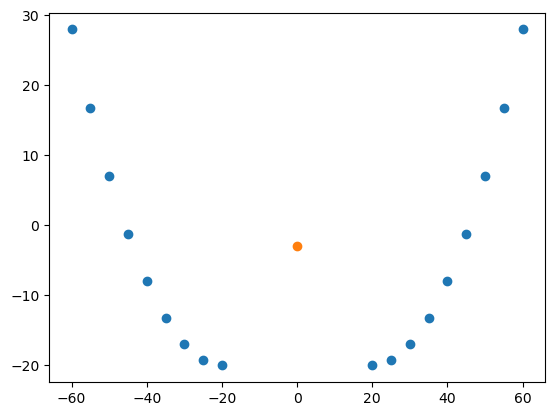

In [12]:
import matplotlib.pyplot as plt
import torch
ridge_x = torch.arange(0,40+5,step=5).float()
ridge_y = 0.03 * (ridge_x ** 2) - 20 
ridge_x = ridge_x + 20
ridge_x = torch.hstack([-ridge_x.flip(dims=[0]), ridge_x]) # mirror effect
ridge_y = torch.hstack([ridge_y.flip(dims=[0]), ridge_y])
plt.scatter(ridge_x, ridge_y)
plt.scatter(
    torch.mean(ridge_x),
    torch.mean(ridge_y)
)


In [48]:
def create_custom_cylinder(
):
    pass

tensor([ 0.1000,  1.7500,  3.4000,  5.0500,  6.7000,  8.3500, 10.0000])

In [7]:
ridge_x.flip(dims=[0])

tensor([60, 55, 50, 45, 40, 35, 30, 25, 20])

In [29]:
_.shape

torch.Size([4, 18, 3])

In [20]:
_1.shape

torch.Size([18, 3])

In [26]:
torch.Tensor([1]).item()

1.0

In [2]:

{1:2,3:4}.values()

dict_values([2, 4])

In [1]:
from panda3d.core import NodePath

In [2]:
help(NodePath.setTransform)

Help on method_descriptor:

setTransform(...) unbound panda3d.core.NodePath method
    C++ Interface:
    set_transform(const NodePath self, const TransformState transform)
    set_transform(const NodePath self, const NodePath other, const TransformState transform, Thread current_thread)
    set_transform(const NodePath self, const TransformState transform, Thread current_thread)
    
    /**
     * Changes the complete transform object on this node.
     */
    
    /**
     * Sets the transform object on this node, relative to the other node.  This
     * computes a new transform object that will have the indicated value when
     * seen from the other node.
     */



In [7]:
class MyClass:
    def __init__(self, name):
        self.name = name
    
    # 定义一个装饰器作为类的成员方法
    def my_decorator(self, func):
        def wrapper(*args, **kwargs):
            print(f"Decorator: Hello from {self.name}")
            return func(*args, **kwargs)
        return wrapper

    # 在运行时应用装饰器
    def greet(self):
        @self.my_decorator  # 运行时应用装饰器
        def inner():
            print("Hello, World!")
        inner()

# 实例化类
obj = MyClass("MyClassInstance")
# 调用被装饰的greet方法
obj.greet()


Decorator: Hello from MyClassInstance
Hello, World!


In [10]:
help(TransformState.makeLookAt)

AttributeError: type object 'panda3d.core.TransformState' has no attribute 'makeLookAt'